In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import os
import scipy.io
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.signal import hilbert
from tensorflow.keras.layers import Lambda
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import to_categorical
import seaborn as sns

DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/Renamed Data"
# DATASET_PATH = "/content/drive/MyDrive/FYP Phase II/Renamed Data"

In [16]:
def max_time_stamps():
    max_time = 0
    time = []
    for file_name in tqdm(os.listdir(DATASET_PATH), desc="Max time stamps computing"):
        if file_name.endswith(".npy"):
            file_path = os.path.join(DATASET_PATH, file_name)
            mel_spec_db = np.load(file_path)
            time_steps = mel_spec_db.shape[1]
            max_time = max(time_steps,max_time)
            time.append(time_steps)
    return time
def pad_or_truncate_spectrogram(mel_spec_db, max_time):
    if mel_spec_db.shape[1] < max_time:
        pad_width = max_time - mel_spec_db.shape[1]
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mel_spec_db = mel_spec_db[:, :max_time]
    return mel_spec_db

max_time_steps = max_time_stamps()
print(max_time_steps)
# for file_name in tqdm(os.listdir(DATASET_PATH), desc="Padding spectrogram files"):
#     if file_name.endswith(".npy"):
#         file_path = os.path.join(DATASET_PATH, file_name)
#         mel_spec_db = np.load(file_path)
#         mel_spec_db = pad_or_truncate_spectrogram(mel_spec_db, max_time_steps)
#         np.save(file_path, mel_spec_db)


Max time stamps computing: 100%|██████████| 159/159 [00:01<00:00, 85.00it/s] 

[1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280, 1280]


# **CNN Based**

In [17]:
# Define fixed padding size (modify based on dataset)
FIXED_MFCC_SHAPE = (13, 1280)  # (num_mfcc, time_steps)

# Function to load and pad .npy files
def load_data(dataset_path):
    X, Y = [], []

    for file in os.listdir(dataset_path):
        if file.endswith('.npy'):
            file_path = os.path.join(dataset_path, file)
            mfcc_data = np.load(file_path)

            # Pad or truncate to fixed shape
            pad_width = [(0, max(0, FIXED_MFCC_SHAPE[0] - mfcc_data.shape[0])),
                         (0, max(0, FIXED_MFCC_SHAPE[1] - mfcc_data.shape[1]))]
            mfcc_padded = np.pad(mfcc_data, pad_width, mode='constant')[:FIXED_MFCC_SHAPE[0], :FIXED_MFCC_SHAPE[1]]

            label = 'Normal' if file.startswith('Normal_') else file.split('_')[3]

            X.append(mfcc_padded)
            Y.append(label)

    return np.array(X), np.array(Y)

# Load dataset
X, Y = load_data(DATASET_PATH)

# Convert labels to numerical format

label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)  # Convert text labels to integers

# Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Reshape for CNN input (adding channel dimension)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# CNN Model
def build_cnn(input_shape, num_classes):
    model = keras.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        # layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        # layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        # layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        # layers.BatchNormalization(),
        layers.MaxPooling2D((1,2)),  # Adjusted pooling to avoid negative dimensions

        layers.Conv2D(512, (3,3), activation='relu', padding='same'),
        # layers.BatchNormalization(),
        layers.MaxPooling2D((1,2)),

        # 🔹 **New Conv Layer**
        layers.Conv2D(1024, (3,3), activation='relu', padding='same'),
        # layers.BatchNormalization(),

        layers.Flatten(),
        layers.Dense(1024, activation='relu'),  # Increased neurons
        layers.Dropout(0.15),  # Reduced dropout
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Model Training
input_shape = (FIXED_MFCC_SHAPE[0], FIXED_MFCC_SHAPE[1], 1)
num_classes = len(np.unique(Y))
model = build_cnn(input_shape, num_classes)
# First Train with Adam
optimizer_adam = keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer_adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=100, batch_size=16, validation_data=(X_test, Y_test))



# Evaluate Model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Save Model
model.save("/content/drive/MyDrive/Colab Notebooks/motor_fault_cnn_2.h5")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 761ms/step - accuracy: 0.3383 - loss: 3.7278 - val_accuracy: 0.4688 - val_loss: 1.1715
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4232 - loss: 1.2069 - val_accuracy: 0.4688 - val_loss: 1.1084
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4389 - loss: 1.1391 - val_accuracy: 0.4688 - val_loss: 1.1381
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4841 - loss: 1.0998 - val_accuracy: 0.4688 - val_loss: 1.0100
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4773 - loss: 1.0122 - val_accuracy: 0.5000 - val_loss: 1.0299
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4811 - loss: 1.1094 - val_accuracy: 0.5000 - val_loss: 0.9662
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5858 - loss: 0.9440 - val_accuracy: 0.5000 - val_loss: 0.9548
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5325 - loss: 0.9956 - val_accuracy: 0.5625 - val_los

Test Accuracy: 0.9062


In [18]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 13, 1280, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 640, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 6, 640, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 3, 320, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 3, 320, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 1, 160, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 1, 160, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 1, 80, 256)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 1, 80, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 1, 40, 512)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 1, 40, 1024)         │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 40960)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │      41,944,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 144,707,342 (552.01 MB)

 Trainable params: 48,235,780 (184.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 96,471,562 (368.01 MB)

# **RNN Based**

In [6]:
from tensorflow.keras import layers, models, regularizers
from sklearn.preprocessing import StandardScaler

FIXED_MFCC_SHAPE = (13, 1280)

# Normalize MFCC data (important for RNNs)
def normalize_data(X):
    X_reshaped = X.reshape(X.shape[0], -1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_reshaped)
    return X_scaled.reshape(X.shape)

# Load + Normalize
X, Y = load_data(DATASET_PATH)
X = normalize_data(X)

# Encode labels
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# 🔁 RNN Model (Bidirectional + Dropout)
def build_improved_rnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.BatchNormalization(),

        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Dropout(0.3),

        layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
        layers.Dropout(0.3),

        layers.TimeDistributed(layers.Dense(64, activation='relu')),
        layers.GlobalAveragePooling1D(),

        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.4),

        layers.Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (FIXED_MFCC_SHAPE[0], FIXED_MFCC_SHAPE[1])  # (time_steps, features)
num_classes = len(np.unique(Y))

model = build_improved_rnn(input_shape, num_classes)
optimizer = keras.optimizers.Adam(learning_rate=0.0003, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(X_train, Y_train, epochs=80, batch_size=16, validation_data=(X_test, Y_test))

# Evaluate
loss, acc = model.evaluate(X_test, Y_test)
print(f"Improved RNN Test Accuracy: {acc:.4f}")

# Save
model.save("/content/drive/MyDrive/motor_fault_rnn_improved.h5")


Epoch 1/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.3679 - loss: 1.4314 - val_accuracy: 0.4688 - val_loss: 1.3256
Epoch 2/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4785 - loss: 1.2804 - val_accuracy: 0.4688 - val_loss: 1.2610
Epoch 3/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4776 - loss: 1.2472 - val_accuracy: 0.4688 - val_loss: 1.2327
Epoch 4/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4054 - loss: 1.2567 - val_accuracy: 0.4688 - val_loss: 1.2034
Epoch 5/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5047 - loss: 1.1519 - val_accuracy: 0.4688 - val_loss: 1.1865
Epoch 6/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5464 - loss: 1.1463 - val_accuracy: 0.4688 - val_loss: 1.1569
Epoch 7/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5033 - loss: 1.1299 - val_accuracy: 0.4688 - val_loss: 1.1457
Epoch 8/80
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5623 - loss: 1.1080 - val_accuracy: 0.4688 - val_loss: 1.1506

Improved RNN Test Accuracy: 0.8125


In [7]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_2                │ (None, 13, 1280)            │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 13, 128)             │         688,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 13, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 13, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 13, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 13, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,423,886 (9.25 MB)

 Trainable params: 807,108 (3.08 MB)

 Non-trainable params: 2,560 (10.00 KB)

 Optimizer params: 1,614,218 (6.16 MB)

# **Hybrid Model**

In [8]:
FIXED_MFCC_SHAPE = (13, 1280)  # (num_mfcc, time_steps)
# Function to load and pad .npy files
def load_data(dataset_path):
    X, Y = [], []
    for file in os.listdir(dataset_path):
        if file.endswith('.npy'):
            file_path = os.path.join(dataset_path, file)
            mfcc_data = np.load(file_path)

            # Pad or truncate to fixed shape
            pad_width = [(0, max(0, FIXED_MFCC_SHAPE[0] - mfcc_data.shape[0])),
                         (0, max(0, FIXED_MFCC_SHAPE[1] - mfcc_data.shape[1]))]
            mfcc_padded = np.pad(mfcc_data, pad_width, mode='constant')[:FIXED_MFCC_SHAPE[0], :FIXED_MFCC_SHAPE[1]]

            # Assign label
            if file.startswith('Normal_'):
                label = 'Normal'
            else:
                label = file.split('_')[3]

            X.append(mfcc_padded)
            Y.append(label)

    return np.array(X), np.array(Y)

# Load dataset
X, Y = load_data(DATASET_PATH)
# Convert labels to numerical format
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Y)  # Convert text labels to integers

# Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Reshape for CNN input (adding channel dimension)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

def build_cnn_rnn(input_shape, num_classes):
    model = keras.Sequential([
        # CNN Feature Extraction
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        # 🔹 Use Global Average Pooling
        layers.GlobalAveragePooling2D(),

        # 🔹 Reshape for RNN (Maintain Temporal Structure)
        layers.Reshape((-1, 128)),

        # 🔹 Use GRU Instead of LSTM for Faster Training
        layers.GRU(64, return_sequences=True),
        layers.GRU(64, return_sequences=False),
        layers.Reshape((1, 64)),
        # 🔹 Small Conv1D Layer to Refine RNN Output
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.GlobalAveragePooling1D(),

        # Fully Connected Layers
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


# Model Training
input_shape = (FIXED_MFCC_SHAPE[0], FIXED_MFCC_SHAPE[1], 1)
num_classes = len(np.unique(Y))

model = build_cnn_rnn(input_shape, num_classes)
optimizer = keras.optimizers.Adam(learning_rate=0.0003, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train Model
history = model.fit(X_train, Y_train, epochs=100, batch_size=16, validation_data=(X_test, Y_test))


# Evaluate Model
test_loss, test_acc = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Save Model
model.save("/content/drive/MyDrive/motor_fault_cnn_rnn-2.h5")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.2546 - loss: 1.3786 - val_accuracy: 0.4688 - val_loss: 1.3420
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4220 - loss: 1.3333 - val_accuracy: 0.4688 - val_loss: 1.2851
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4839 - loss: 1.2632 - val_accuracy: 0.4688 - val_loss: 1.2307
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5032 - loss: 1.2082 - val_accuracy: 0.4688 - val_loss: 1.1991
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4014 - loss: 1.2482 - val_accuracy: 0.4688 - val_loss: 1.1774
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4140 - loss: 1.1925 - val_accuracy: 0.4688 - val_loss: 1.1610
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4455 - loss: 1.1770 - val_accuracy: 0.4688 - val_loss: 1.1526
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5080 - loss: 1.1405 - val_accuracy: 0.4688 - val_loss: 1.1431
Epoc

Test Accuracy: 0.9375


# **Evaluation**

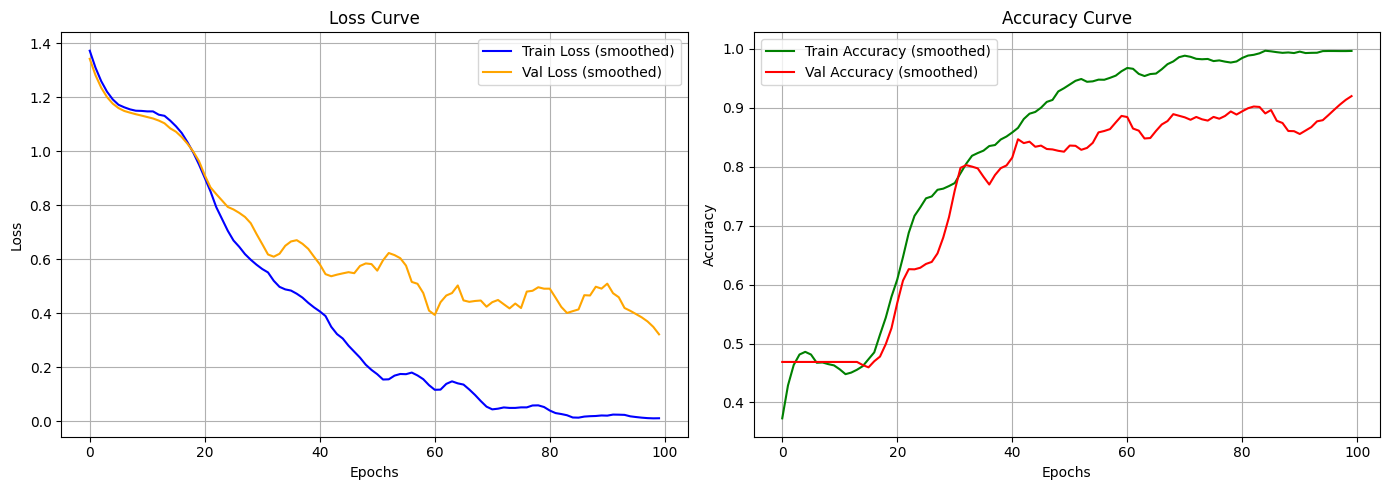

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Smooth the curves using Savitzky-Golay filter
def smooth_curve(data, window=11, poly=3):
    if len(data) < window:
        return data  # too short to smooth
    return savgol_filter(data, window_length=window, polyorder=poly)

# Extract history
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Apply smoothing
loss_smooth = smooth_curve(loss)
val_loss_smooth = smooth_curve(val_loss)
acc_smooth = smooth_curve(acc)
val_acc_smooth = smooth_curve(val_acc)

# Plotting
plt.figure(figsize=(14, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(loss_smooth, label='Train Loss (smoothed)', color='blue')
plt.plot(val_loss_smooth, label='Val Loss (smoothed)', color='orange')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(acc_smooth, label='Train Accuracy (smoothed)', color='green')
plt.plot(val_acc_smooth, label='Val Accuracy (smoothed)', color='red')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step


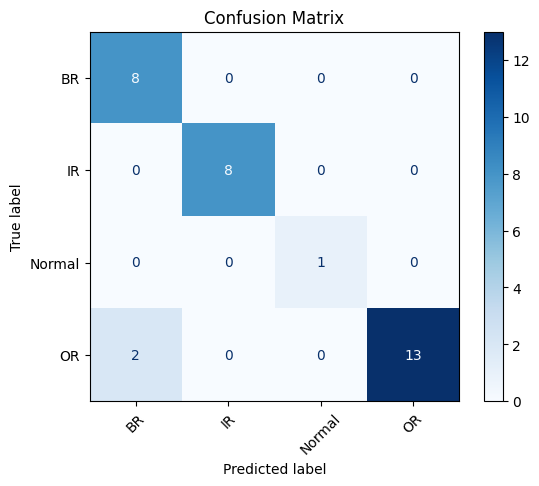

In [10]:
# Predict labels
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(Y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()


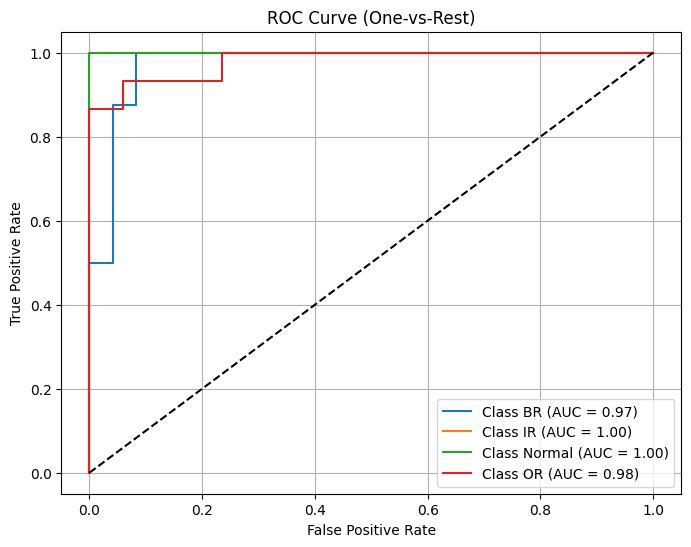

In [11]:
# One-hot encode the true labels
Y_test_bin = label_binarize(Y_test, classes=np.arange(num_classes))
y_score = y_pred  # already softmax probabilities

# Plot ROC
fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (One-vs-Rest)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [12]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 13, 1280, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 640, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 6, 640, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 3, 320, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 3, 320, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 1, 160, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 1, 64)               │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 1, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1, 64)               │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 528,206 (2.01 MB)

 Trainable params: 176,068 (687.77 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 352,138 (1.34 MB)

In [28]:
import time
import numpy as np
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/motor_fault_cnn_rnn.h5")

# Generate a random input sample matching the model's input shape
sample_input = np.random.rand(1, 13, 1280, 1).astype(np.float32)

# Measure inference time over multiple runs
num_trials = 100
total_time = 0

for _ in range(num_trials):
    start_time = time.time()
    _ = model.predict(sample_input, verbose=0)  # Run inference
    end_time = time.time()
    total_time += (end_time - start_time)

# Calculate average latency per inference
average_latency = (total_time / num_trials) * 1000  # Convert to milliseconds

print(f"Average Inference Time: {average_latency:.4f} ms")


Average Inference Time: 66.6799 ms


# **Augmentation**

In [2]:
DATASET2_PATH = "/content/drive/MyDrive/Colab Notebooks/MAT Files"

## faulty vs normal plot

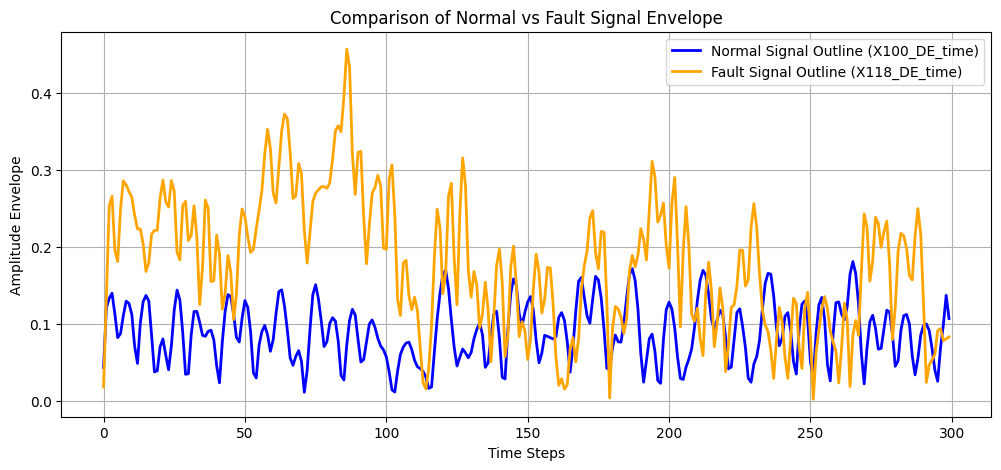

In [29]:
# Function to find the correct key in a .mat file
def find_signal_key(mat_data):
    for key in mat_data.keys():
        if "DE_time" in key:  # Look for the DE (Drive End) signal
            return key
    raise ValueError("No valid signal key found in the .mat file!")

# Function to load and process signal
def load_signal(file_path):
    mat_data = scipy.io.loadmat(file_path)
    signal_key = find_signal_key(mat_data)  # Dynamically find the key
    signal = mat_data[signal_key].squeeze()[:300]  # Limit to 5000 points for clarity
    envelope = np.abs(hilbert(signal))  # Compute the signal envelope
    return envelope, signal_key  # Return both envelope & key
# Provide Paths of Specific Normal & Fault Data Files
normal_file = "/content/drive/MyDrive/Colab Notebooks/MAT Files/Normal_1730.mat"
fault_file = "/content/drive/MyDrive/Colab Notebooks/MAT Files/12K_DE_07_BR_118.mat"

# Load envelope signals dynamically
normal_envelope, normal_key = load_signal(normal_file)
fault_envelope, fault_key = load_signal(fault_file)

# Plot the envelopes
plt.figure(figsize=(12, 5))
plt.plot(normal_envelope, label=f"Normal Signal Outline ({normal_key})", color="blue", linewidth=2)
plt.plot(fault_envelope, label=f"Fault Signal Outline ({fault_key})", color="orange", linewidth=2)

plt.title("Comparison of Normal vs Fault Signal Envelope")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude Envelope")
plt.legend()
plt.grid()

plt.show()


In [15]:
file_path = "/content/drive/MyDrive/Colab Notebooks/MAT Files/Normal_1730.mat"

mat_data = scipy.io.loadmat(file_path)

print("Keys in .mat file:", mat_data.keys())

Keys in .mat file: dict_keys(['__header__', '__version__', '__globals__', 'X100_DE_time', 'X100_FE_time', 'X100RPM'])
